In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import scipy

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)

## load data

In [4]:
pth_data = '../../data/train.csv'
df_origin = pd.read_csv(pth_data)

In [5]:
df_origin

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
0,2020-10-19 14:00:00,1.64,54.0,1,20.077335,24,77.990,62.122,60.0,17.0,NaN,NaN,4.0,4.0,0.74,1.0
1,2020-10-19 14:30:00,1.64,54.0,1,20.077335,24,78.208,62.321,78.0,60.0,30.748,0.926320,4.0,4.0,0.74,1.1
2,2020-10-19 15:00:00,1.64,54.0,1,20.077335,24,78.514,62.255,79.0,46.0,31.327,1.232405,4.0,4.0,0.74,1.1
3,2020-10-19 15:30:00,1.64,54.0,1,20.077335,24,79.041,61.491,94.0,91.0,31.458,0.375005,4.0,4.0,0.74,1.0
4,2020-10-19 16:00:00,1.64,54.0,1,20.077335,24,79.435,61.071,85.0,71.0,32.085,0.081127,4.0,4.0,0.74,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,2020-10-28 21:30:00,1.63,50.0,1,18.818924,23,76.528,40.530,73.0,22.0,31.850,0.114876,2.0,3.0,0.50,1.0
2792,2020-10-28 22:00:00,1.63,50.0,1,18.818924,23,76.876,39.890,70.5,10.0,32.215,0.146231,2.0,3.0,0.50,1.0
2793,2020-10-28 22:30:00,1.63,50.0,1,18.818924,23,77.050,39.710,72.0,5.0,32.656,0.153838,2.0,3.0,0.50,1.0
2794,2020-10-28 23:00:00,1.63,50.0,1,18.818924,23,76.703,39.980,66.0,0.0,31.902,0.160930,2.0,3.0,0.50,1.0


In [6]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796 entries, 0 to 2795
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2796 non-null   object 
 1   height        2796 non-null   float64
 2   weight        2796 non-null   float64
 3   gender        2796 non-null   int64  
 4   bmi           2796 non-null   float64
 5   age           2796 non-null   int64  
 6   env_temp      2796 non-null   float64
 7   rh            2796 non-null   float64
 8   heart_rate    2201 non-null   float64
 9   stress_level  1848 non-null   float64
 10  skin_temp     1874 non-null   float64
 11  eda           2396 non-null   float64
 12  TC            2717 non-null   float64
 13  TS            2712 non-null   float64
 14  Clo           2737 non-null   float64
 15  Act           2718 non-null   float64
dtypes: float64(13), int64(2), object(1)
memory usage: 349.6+ KB


## data process

### choose data: TS < 4.0
|Thermal Sensation（TS）	| |
|---|---|
|1|	Very uncomfortable|
|2|	Uncomfortable|
|3|	Slightly uncomfortable|
|4|	Neutral|
|5|	Slightly comfortable|
|6|	Comfortable|
|7|	Very comfortable|

In [7]:
df_origin[df_origin[['TS']].isna().TS].shape
# some na in clo, means unrecorded data

(84, 16)

In [8]:
df_ts_nona = df_origin[df_origin['TS'].isna() ^ True]

In [10]:
df_ts_nona.shape

(2712, 16)

In [11]:
df_ts_edge = df_ts_nona[df_ts_nona['TS'] < 4.0]

In [12]:
df_ts_edge.shape

(394, 16)

In [13]:
df_ts_edge.head()

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
50,2020-10-21 02:30:00,1.64,54.0,1,20.077335,24,78.427,61.044,81.0,7.0,32.552,0.169282,3.0,3.0,0.74,1.0
51,2020-10-21 03:00:00,1.64,54.0,1,20.077335,24,78.382,61.040,65.0,2.0,32.474,0.171619,3.0,3.0,0.74,1.0
52,2020-10-21 03:30:00,1.64,54.0,1,20.077335,24,78.121,60.745,NaN,0.0,32.889,0.177812,3.0,3.0,0.74,1.0
53,2020-10-21 04:00:00,1.64,54.0,1,20.077335,24,78.121,60.835,58.0,0.0,32.292,0.172982,3.0,2.0,0.74,1.0
62,2020-10-21 16:00:00,1.64,54.0,1,20.077335,24,77.945,61.636,70.0,20.0,32.059,0.263771,3.0,3.0,0.74,1.0


### choose data: TC > 4.0 

In [16]:
df_ts_edge[df_ts_edge[['TC']].isna().TC].shape

(0, 16)

In [17]:
df_TC_nona = df_ts_edge[df_ts_edge['TC'].isna() ^ True]

In [18]:
df_comfort_edge_high = df_TC_nona[df_TC_nona['TC'] > 4.0]

In [19]:
df_comfort_edge_high = df_comfort_edge_high[df_comfort_edge_high['TC'] < 7.0]

In [20]:
df_comfort_edge_high.shape

(49, 16)

In [21]:
df_comfort = df_comfort_edge_high
df_comfort

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
85,2020-10-19 13:30:00,1.77,90.0,-1,28.727377,28,79.480,60.389,67.0,NaN,31.013,0.188456,6.0,3.0,0.36,1.1
86,2020-10-19 14:00:00,1.77,90.0,-1,28.727377,28,81.023,60.400,84.0,42.0,33.790,6.623951,6.0,2.0,0.36,1.1
87,2020-10-19 14:30:00,1.77,90.0,-1,28.727377,28,80.227,60.113,86.0,NaN,33.199,4.282520,6.0,2.0,0.36,1.1
88,2020-10-19 15:00:00,1.77,90.0,-1,28.727377,28,81.597,59.860,94.0,75.0,33.482,3.446370,6.0,2.0,0.36,1.1
112,2020-10-20 14:30:00,1.77,90.0,-1,28.727377,28,78.559,61.233,79.0,NaN,33.430,0.289664,6.0,3.0,0.57,1.4
113,2020-10-20 15:00:00,1.77,90.0,-1,28.727377,28,80.008,61.459,83.0,78.0,30.537,0.422045,6.0,3.0,0.57,1.7
114,2020-10-20 15:30:00,1.77,90.0,-1,28.727377,28,81.023,61.638,91.0,83.0,33.250,8.697113,6.0,3.0,0.36,1.1
128,2020-10-20 22:30:00,1.77,90.0,-1,28.727377,28,75.853,59.548,135.0,NaN,31.458,57.415932,5.0,3.0,0.36,3.8
205,2020-10-20 22:30:00,1.77,58.0,-1,18.513199,23,79.480,55.272,87.0,NaN,32.915,0.006857,5.0,3.0,0.36,1.0
416,2020-10-20 12:00:00,1.80,75.0,-1,23.148148,33,85.194,48.290,67.0,17.0,31.850,4.085208,6.0,3.0,0.31,1.0


### visualization

In [22]:
df_visual = df_comfort[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'Clo', 'Act', 'env_temp']]

In [23]:
df_visual.head()

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,env_temp
85,1.77,90.0,-1,28.727377,28,60.389,67.0,NaN,31.013,0.188456,0.36,1.1,79.480
86,1.77,90.0,-1,28.727377,28,60.400,84.0,42.0,33.790,6.623951,0.36,1.1,81.023
87,1.77,90.0,-1,28.727377,28,60.113,86.0,NaN,33.199,4.282520,0.36,1.1,80.227
88,1.77,90.0,-1,28.727377,28,59.860,94.0,75.0,33.482,3.446370,0.36,1.1,81.597
112,1.77,90.0,-1,28.727377,28,61.233,79.0,NaN,33.430,0.289664,0.57,1.4,78.559


#### pairplot
download it to zoom in

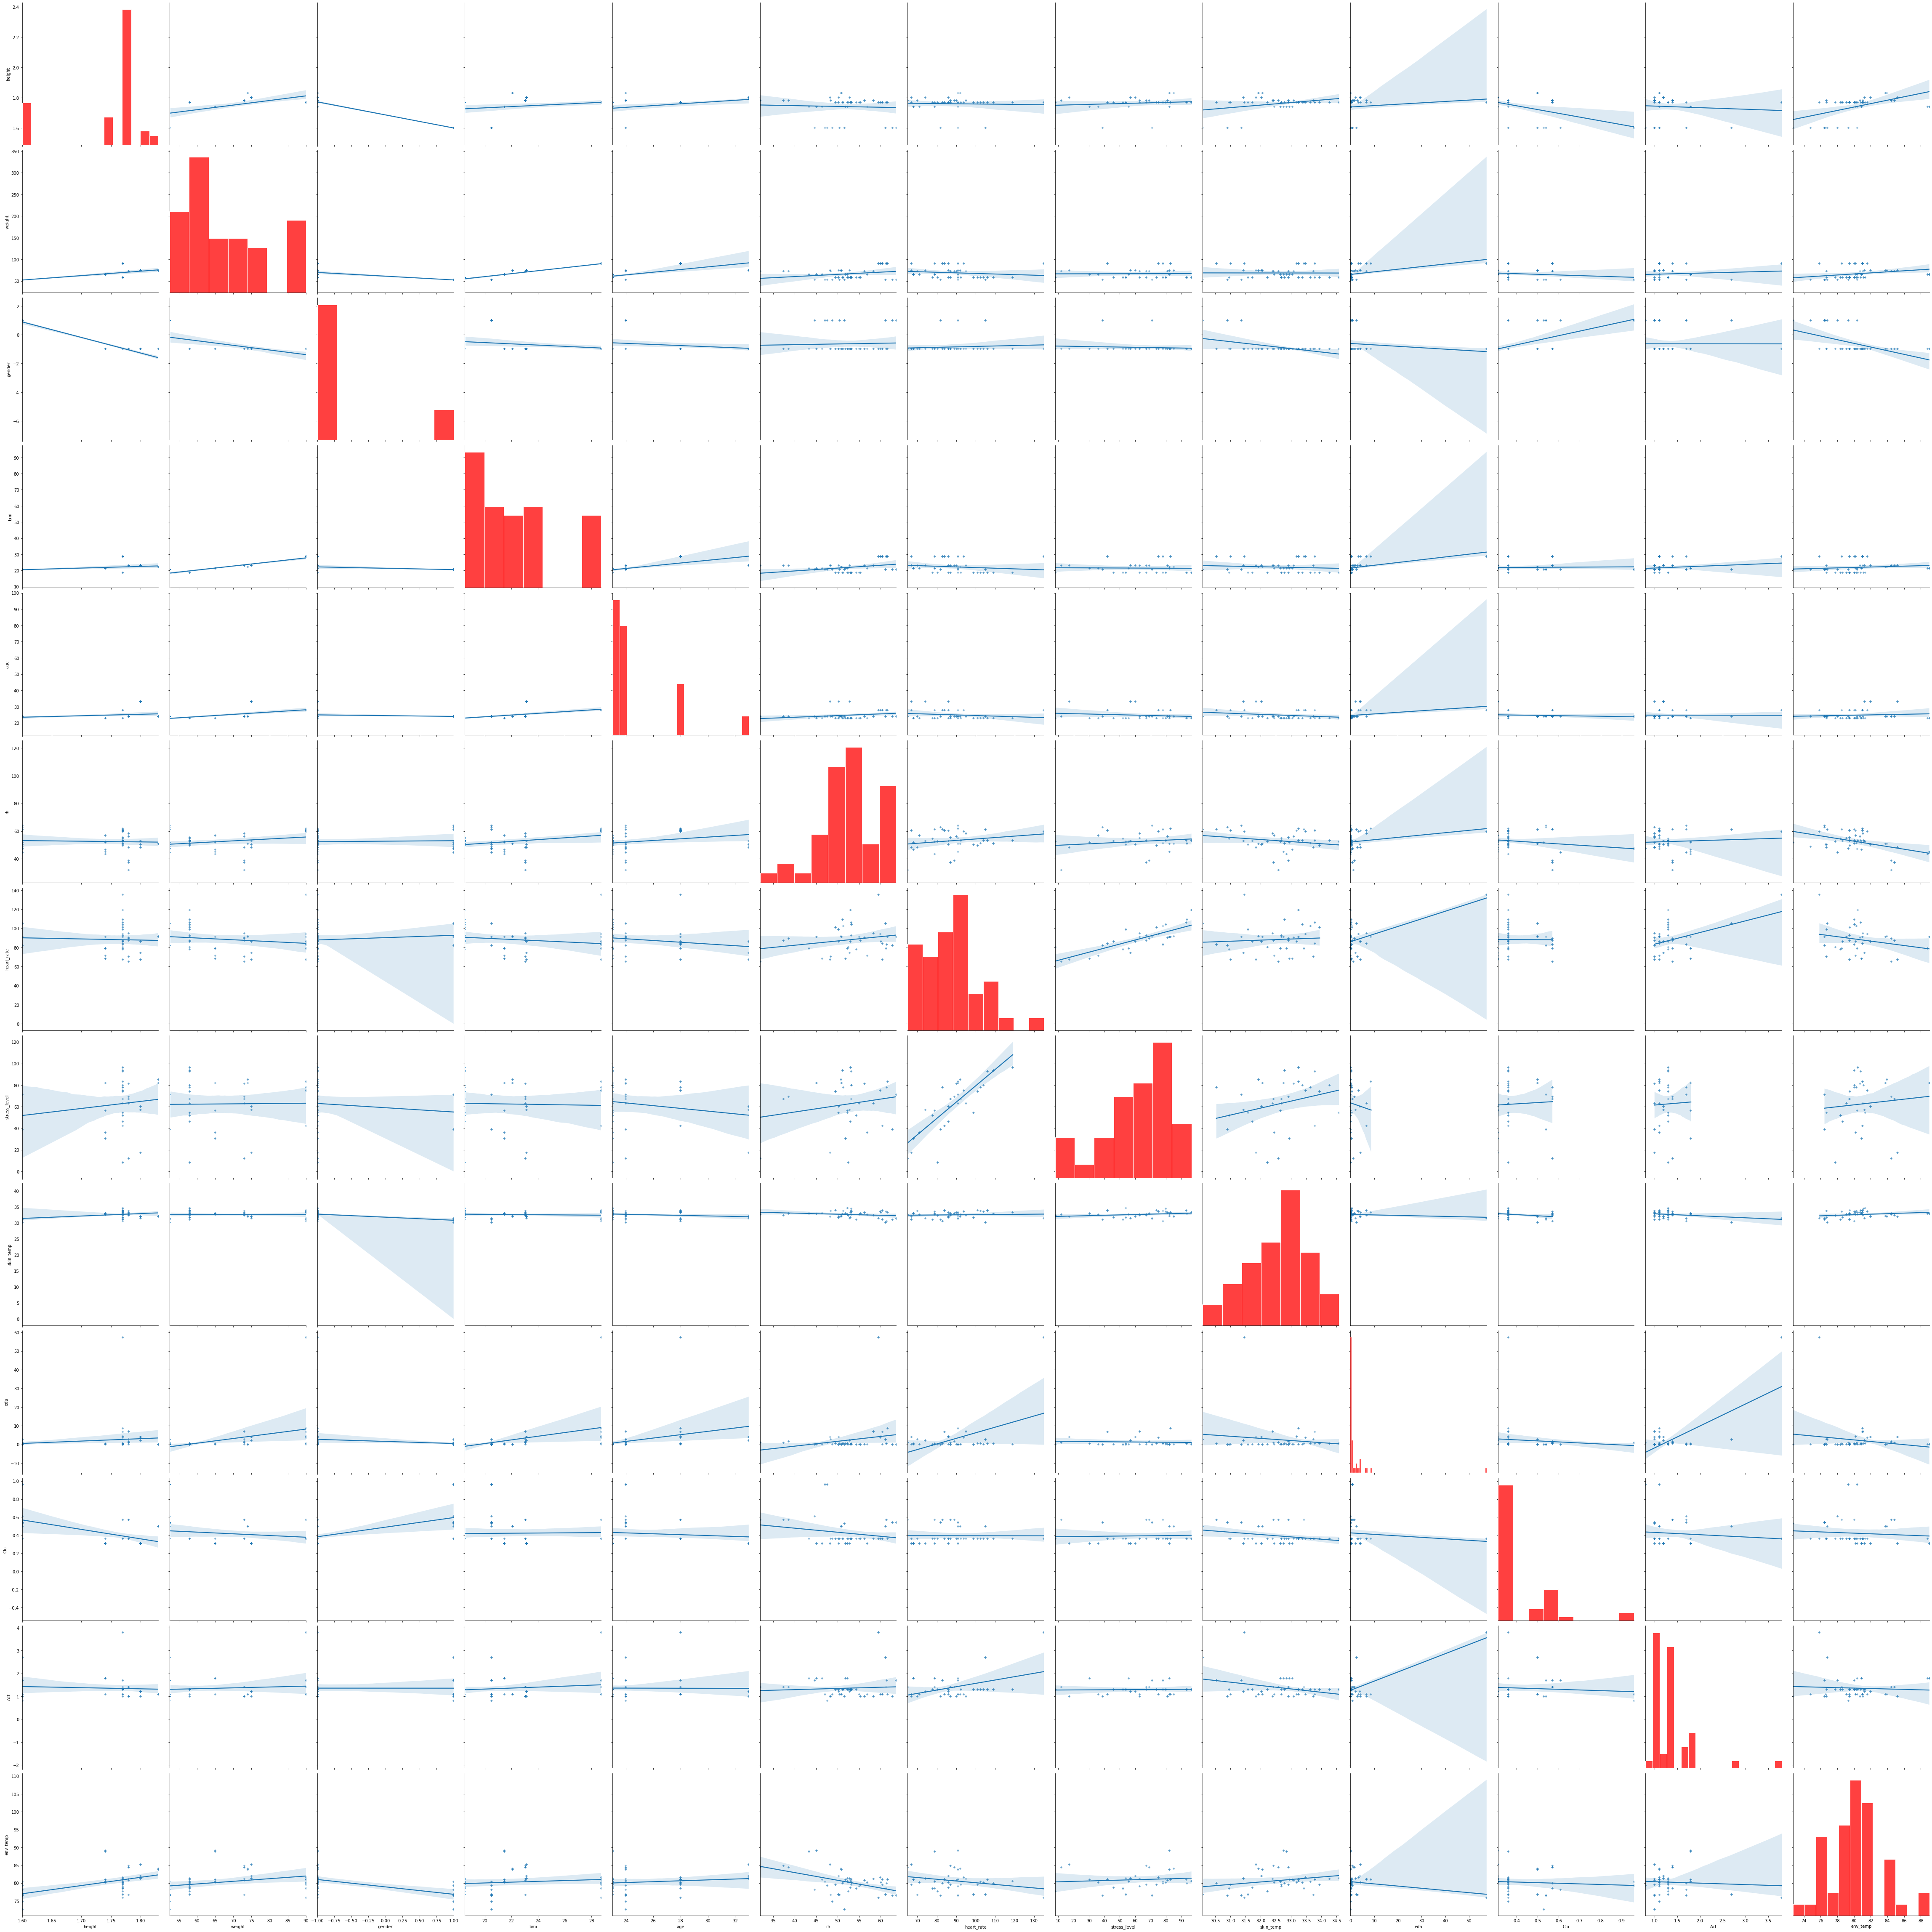

In [24]:
sns.pairplot(df_visual, dropna=True, kind='reg', markers='+', height=5, aspect=1,
            diag_kws=dict(edgecolor="w", color="r"))

#### correlation map

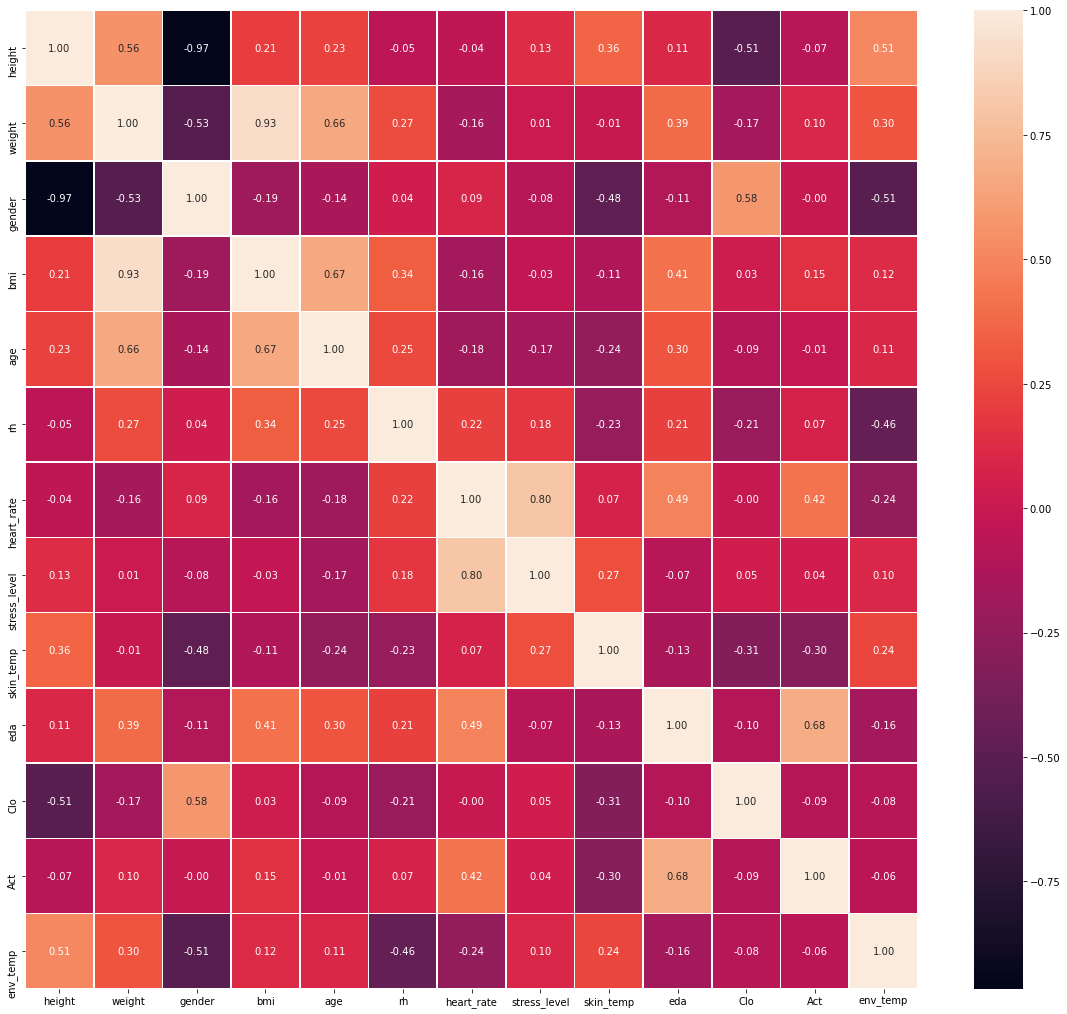

In [25]:
# correlation map
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(df_visual.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### shuffle

In [26]:
df_shuffle = df_comfort.sample(frac=1, random_state=1208).reset_index(drop=True)

In [27]:
X_data = df_shuffle[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'Clo', 'Act']]

In [28]:
X_cols_name = X_data.columns

In [29]:
y_data = df_shuffle['env_temp']

### imputation

In [30]:
df_comfort[df_comfort[['env_temp']].isna().env_temp]
# no na in env_temp

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act


In [31]:
imp = SimpleImputer(strategy='mean')

In [32]:
X_data = pd.DataFrame(imp.fit_transform(X_data), columns=X_cols_name)

In [33]:
X_data_not_norm = pd.DataFrame(imp.fit_transform(X_data), columns=X_cols_name)

### normalize
linear regression need this. random forest doesn't need

In [34]:
X_array_normalize, X_norm = normalize(X_data, axis=0, return_norm=True)

In [35]:
X_data = pd.DataFrame(X_array_normalize, columns=X_cols_name)

In [36]:
X_data

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act
0,0.145155,0.122216,-0.142857,0.119346,0.131827,0.148479,0.145813,0.137864,0.143332,0.002157,0.115459,0.109211
1,0.131213,0.110626,0.142857,0.132204,0.137559,0.165250,0.168246,0.136737,0.131951,0.042911,0.160359,0.268064
2,0.145975,0.153823,-0.142857,0.148528,0.137559,0.152044,0.144211,0.177253,0.145148,0.001334,0.115459,0.099283
3,0.145155,0.189645,-0.142857,0.185192,0.160485,0.165946,0.132994,0.170688,0.133925,0.007079,0.182810,0.168781
4,0.131213,0.110626,0.142857,0.132204,0.137559,0.120644,0.141260,0.136737,0.142796,0.000535,0.195638,0.168781
5,0.131213,0.110626,0.142857,0.132204,0.137559,0.169470,0.131392,0.085344,0.135547,-0.000534,0.173188,0.099283
6,0.145155,0.189645,-0.142857,0.185192,0.160485,0.166430,0.145813,0.181630,0.145823,0.145887,0.115459,0.109211
7,0.145155,0.122216,-0.142857,0.119346,0.131827,0.149241,0.139404,0.136737,0.144354,0.000115,0.115459,0.099283
8,0.145155,0.189645,-0.142857,0.185192,0.160485,0.160787,0.216316,0.136737,0.137964,0.963103,0.115459,0.377275
9,0.145155,0.122216,-0.142857,0.119346,0.131827,0.135646,0.158632,0.118169,0.138534,0.000300,0.115459,0.129068


In [37]:
X_norm

array([ 12.19387141, 474.57059538,   7.        , 155.12239897,
       174.4706279 , 370.35432569, 624.0874703 , 456.97366414,
       228.01611338,  59.61554069,   3.11799615,  10.07223908])

## refine data

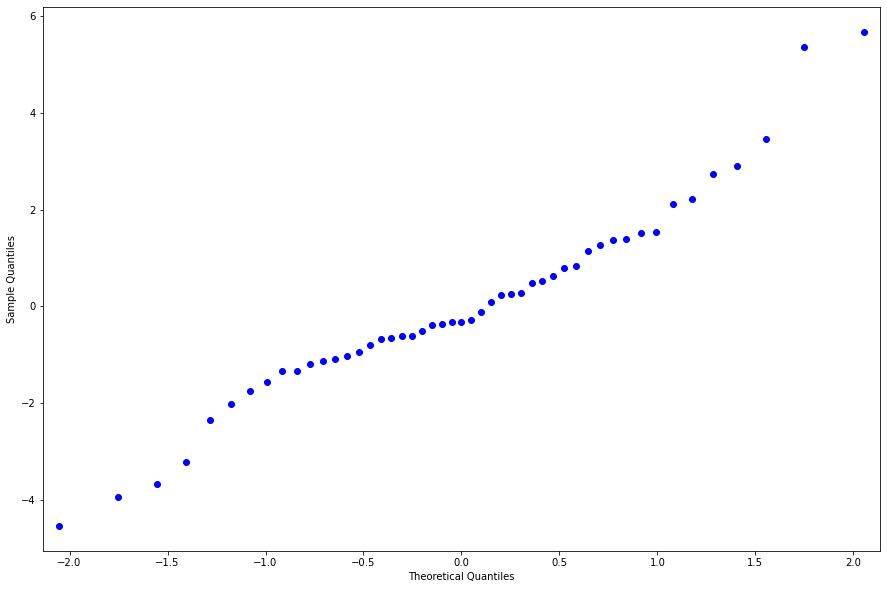

In [56]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.qqplot(regr_fit.resid)
plt.show()

In [38]:
regr = sm.OLS(y_data, X_data)
regr_fit = regr.fit()

### leverage & outlier

In [39]:
infl = regr_fit.get_influence()

In [40]:
# leverage
leviers = infl.hat_matrix_diag
# list(leviers)

In [41]:
# studentized residue
res_studs = infl.resid_studentized_external
# list(res_studs)

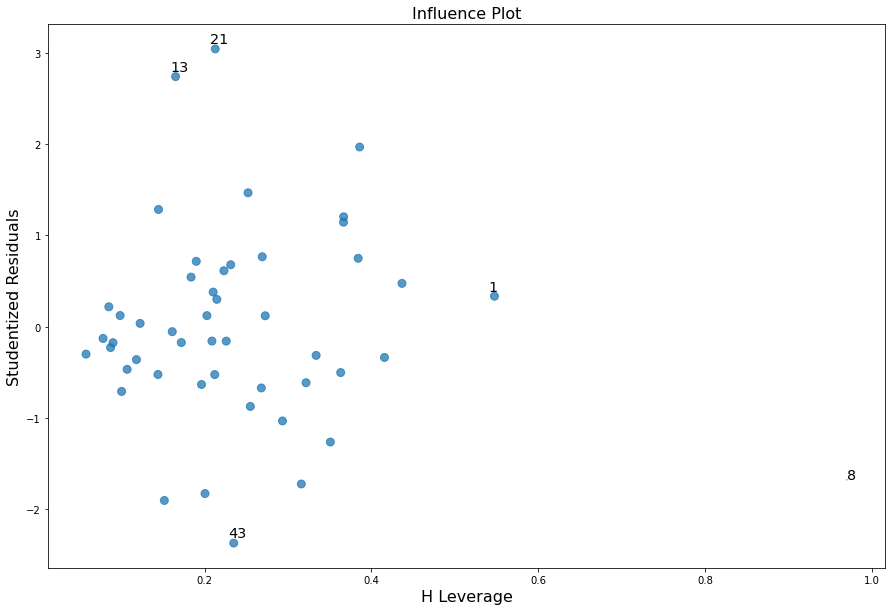

In [55]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.graphics.influence_plot(regr_fit, size=0.5)
plt.show()

### leverage detection
the threshold value may be:
$$s_h=2\times \frac{p+1}{n}$$

In [42]:
n_data = X_data.shape[0]
p_data = X_data.shape[1]

In [43]:
s_h = 2 * (p_data + 1) / n_data
s_h

0.5306122448979592

In [44]:
atyp_levier = leviers > s_h

In [45]:
len(leviers[atyp_levier])

2

### outlier detection
Threshold:
$$s_t=t_{1-0.05/2}(n-p-2)$$

In [46]:
seuil_stud = scipy.stats.t.ppf(0.975, df=n_data-p_data-2)
seuil_stud

2.0301079282503425

In [47]:
atyp_stud = np.abs(res_studs) > seuil_stud
atyp_stud

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False])

In [48]:
idx_eliminate_lvg_outl = np.logical_not(np.logical_or(atyp_levier, atyp_stud))

In [49]:
X_data.index[idx_eliminate_lvg_outl]

Int64Index([ 0,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19,
            20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
            38, 39, 40, 41, 42, 44, 45, 46, 47, 48],
           dtype='int64')

In [50]:
X_data_refine = X_data[idx_eliminate_lvg_outl]
y_data_refine = y_data[idx_eliminate_lvg_outl]

### save refine data (not normalized)

In [51]:
X_data_refine_not_norm = X_data_not_norm[idx_eliminate_lvg_outl]
y_data_refine_not_norm = y_data[idx_eliminate_lvg_outl]

In [52]:
df_refine_not_norm = pd.concat([X_data_refine_not_norm, y_data_refine_not_norm], axis=1)

In [53]:
df_refine_not_norm.to_csv('../processed_data/train_refine_not_norm_max.csv', index=False)

In [54]:
df_refine_not_norm

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,env_temp
0,1.77,58.0,-1.0,18.513199,23.0,54.990,91.000000,63.000000,32.682000,0.128582,0.36,1.1,79.084
2,1.78,73.0,-1.0,23.040020,24.0,56.310,90.000000,81.000000,33.096000,0.079552,0.36,1.0,80.735
3,1.77,90.0,-1.0,28.727377,28.0,61.459,83.000000,78.000000,30.537000,0.422045,0.57,1.7,80.008
4,1.60,52.5,1.0,20.507812,24.0,44.681,88.158537,62.485294,32.559814,0.031869,0.61,1.7,78.033
5,1.60,52.5,1.0,20.507812,24.0,62.764,82.000000,39.000000,30.907000,-0.031865,0.54,1.0,76.464
6,1.77,90.0,-1.0,28.727377,28.0,61.638,91.000000,83.000000,33.250000,8.697113,0.36,1.1,81.023
7,1.77,58.0,-1.0,18.513199,23.0,55.272,87.000000,62.485294,32.915000,0.006857,0.36,1.0,79.480
9,1.77,58.0,-1.0,18.513199,23.0,50.237,99.000000,54.000000,31.588000,0.017909,0.36,1.3,76.725
10,1.77,90.0,-1.0,28.727377,28.0,60.389,67.000000,62.485294,31.013000,0.188456,0.36,1.1,79.480
11,1.77,58.0,-1.0,18.513199,23.0,53.132,106.000000,93.000000,33.790000,0.322940,0.36,1.3,80.845


## linear regression
try after refine

In [57]:
n_rows = y_data_refine.shape[0]

train_test_fraction = 0.8
n_rows_train = int(n_rows * train_test_fraction)
# n_rows_test = n_rows - n_rows_train

X_train = X_data_refine[:n_rows_train]
y_train = y_data_refine[:n_rows_train]

X_test = X_data_refine[n_rows_train:]
y_test = y_data_refine[n_rows_train:]

In [58]:
regr = sm.OLS(y_train, X_train)

In [59]:
regr_fit = regr.fit()

In [60]:
y_pred = regr_fit.predict(X_test)

In [61]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
39,81.333,81.329340
40,79.524,80.700478
41,79.480,80.270566
42,84.474,83.836588
44,81.975,82.709987
45,78.427,80.382340
46,80.911,81.491645
47,77.727,79.970306
48,80.272,80.413125


In [62]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                              8214.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                    8.86e-39
Time:                        22:30:44   Log-Likelihood:                         -56.696
No. Observations:                  35   AIC:                                      137.4
Df Residuals:                      23   BIC:                                      156.1
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height         550.4637    105.984      5.194      0.000     331.218     769.709
weight           9.1551    148.236      0.062      0.951    -297.494     315.804
gender          11.3198     11.715      0.966      0.344     -12.914      35.553
bmi            -30.0013    151.031     -0.199      0.844    -342.432     282.429
age              2.0419     28.080      0.073      0.943     -56.046      60.130
rh             -34.5267     20.700     -1.668      0.109     -77.348       8.295
heart_rate     -48.2241     30.845     -1.563      0.132    -112.032      15.584
stress_level     8.6920     12.870      0.675      0.506     -17.932      35.316
skin_temp       77.9457     91.871      0.848      0.405    -112.104     267.996
eda             23.8828     11.200      2.132      0.044       0.714      47.052
Clo             17.6495      7.282      2.424      0.024       2.585      32.714
Act             13.6556     12.666      1.078      0.292     -12.546      39.857
==============================================================================
Omnibus:                        5.537   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                4.052
Skew:                          -0.763   Prob(JB):                        0.132
Kurtosis:                       3.671   Cond. No.                         414.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
# mean squared error
mean_squared_error(y_test, y_pred)

1.3520499662825702

In [64]:
# R2 score
r2_score(y_test, y_pred)

0.6295430637469236

## feature selection
seems many features are unrelated with a multi linear regression model

### correlation map for refine data

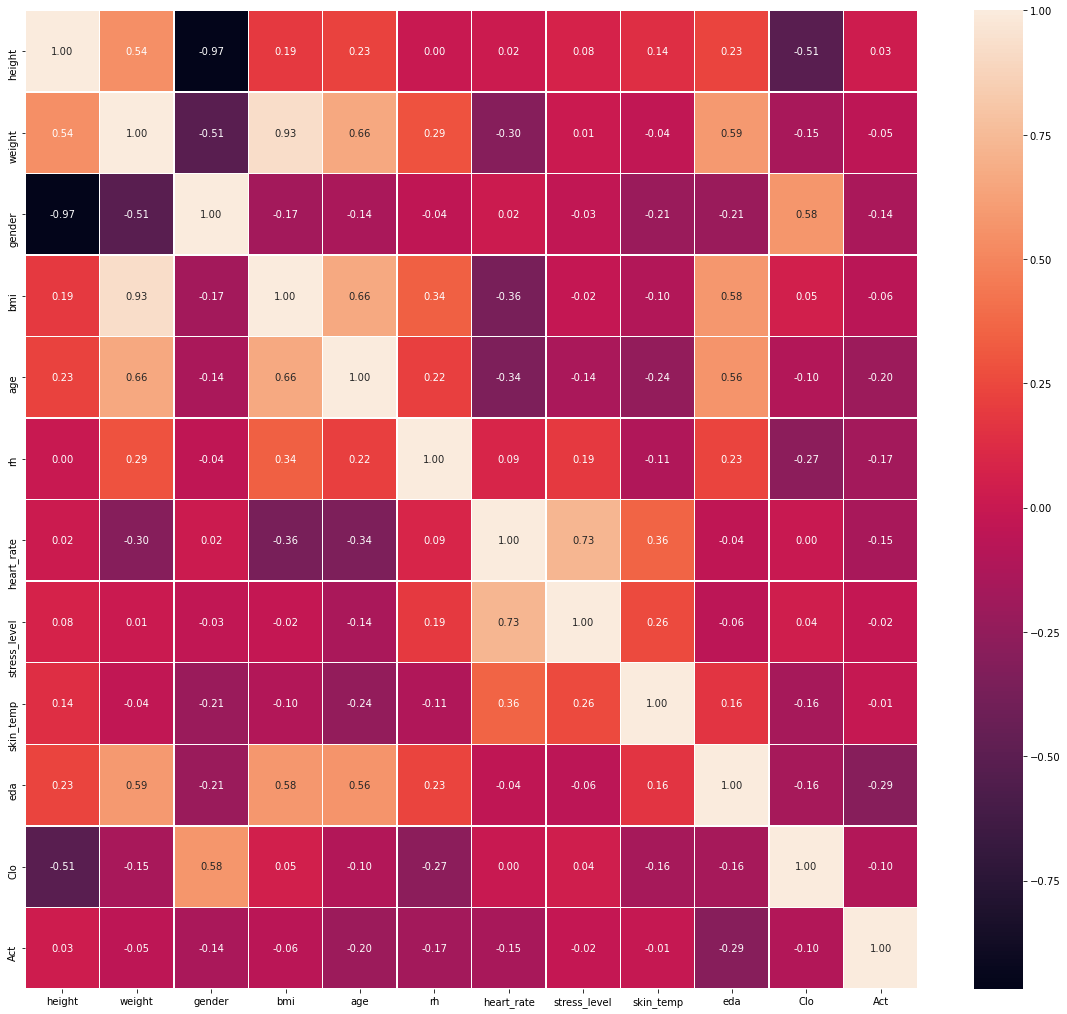

In [65]:
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(X_data_refine.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### backward selection

In [66]:
regr = sm.OLS(y_data_refine, X_data_refine)
regr_fit = regr.fit()

In [67]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.245e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                    3.96e-55
Time:                        22:31:49   Log-Likelihood:                         -69.434
No. Observations:                  44   AIC:                                      162.9
Df Residuals:                      32   BIC:                                      184.3
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height         532.1096     78.733      6.758      0.000     371.736     692.483
weight          12.8364    119.577      0.107      0.915    -230.734     256.407
gender          11.8174     10.204      1.158      0.255      -8.967      32.602
bmi            -24.3314    122.175     -0.199      0.843    -273.194     224.532
age              1.0736     22.183      0.048      0.962     -44.112      46.259
rh             -40.6832     16.339     -2.490      0.018     -73.966      -7.401
heart_rate     -49.9943     22.567     -2.215      0.034     -95.962      -4.026
stress_level    12.8959      8.470      1.522      0.138      -4.358      30.149
skin_temp       93.1618     69.041      1.349      0.187     -47.471     233.795
eda             23.3330      9.549      2.444      0.020       3.882      42.783
Clo             17.4172      6.554      2.658      0.012       4.067      30.767
Act             11.6954     11.178      1.046      0.303     -11.074      34.465
==============================================================================
Omnibus:                        4.135   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                3.004
Skew:                          -0.451   Prob(JB):                        0.223
Kurtosis:                       3.909   Cond. No.                         397.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
X_rm = X_data_refine

#### remove age

In [69]:
X_rm = X_rm.drop(columns='age')

In [70]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.401e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                    3.25e-57
Time:                        22:32:35   Log-Likelihood:                         -69.436
No. Observations:                  44   AIC:                                      160.9
Df Residuals:                      33   BIC:                                      180.5
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height         533.5884     71.457      7.467      0.000     388.208     678.969
weight          14.2578    114.149      0.125      0.901    -217.981     246.496
gender          12.0341      9.030      1.333      0.192      -6.337      30.405
bmi            -25.4543    118.125     -0.215      0.831    -265.782     214.873
rh             -40.6610     16.084     -2.528      0.016     -73.385      -7.937
heart_rate     -50.1581     21.972     -2.283      0.029     -94.861      -5.455
stress_level    12.8861      8.339      1.545      0.132      -4.080      29.852
skin_temp       92.7885     67.564      1.373      0.179     -44.672     230.249
eda             23.4659      9.006      2.606      0.014       5.143      41.789
Clo             17.3394      6.257      2.771      0.009       4.609      30.070
Act             11.7158     11.000      1.065      0.295     -10.664      34.096
==============================================================================
Omnibus:                        4.104   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                2.982
Skew:                          -0.444   Prob(JB):                        0.225
Kurtosis:                       3.916   Cond. No.                         374.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove weight

In [71]:
X_rm = X_rm.drop(columns='weight')

In [154]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.432e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                        0.00
Time:                        22:10:18   Log-Likelihood:                         -542.60
No. Observations:                 285   AIC:                                      1107.
Df Residuals:                     274   BIC:                                      1147.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        1632.8795     91.034     17.937      0.000    1453.664    1812.095
weight        -725.1676     86.528     -8.381      0.000    -895.512    -554.824
gender           3.8942      5.741      0.678      0.498      -7.407      15.195
bmi            720.5043     74.024      9.733      0.000     574.776     866.232
age           -240.7144     49.893     -4.825      0.000    -338.937    -142.491
rh              37.1744      8.818      4.216      0.000      19.815      54.533
heart_rate     -22.7012     17.196     -1.320      0.188     -56.555      11.152
stress_level     0.7770      4.094      0.190      0.850      -7.284       8.838
skin_temp      -56.8753     75.960     -0.749      0.455    -206.415      92.664
Clo            -35.8083      7.676     -4.665      0.000     -50.920     -20.697
Act             56.8750     13.640      4.170      0.000      30.023      83.727
==============================================================================
Omnibus:                        0.398   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.819   Jarque-Bera (JB):                0.292
Skew:                          -0.076   Prob(JB):                        0.864
Kurtosis:                       3.035   Cond. No.                         249.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove stress_level

In [72]:
X_rm = X_rm.drop(columns='stress_level')

In [73]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.677e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                    7.23e-61
Time:                        22:33:51   Log-Likelihood:                         -71.192
No. Observations:                  44   AIC:                                      160.4
Df Residuals:                      35   BIC:                                      176.4
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height       517.0205     53.190      9.720      0.000     409.039     625.002
gender         9.7468      3.633      2.683      0.011       2.372      17.122
bmi            1.0440     15.096      0.069      0.945     -29.603      31.691
rh           -41.7456     14.452     -2.889      0.007     -71.085     -12.406
heart_rate   -21.9923     14.032     -1.567      0.126     -50.478       6.494
skin_temp     82.4330     50.425      1.635      0.111     -19.935     184.801
eda           18.9923      8.514      2.231      0.032       1.709      36.276
Clo           17.1937      6.322      2.720      0.010       4.360      30.028
Act           11.6197      9.620      1.208      0.235      -7.909      31.149
==============================================================================
Omnibus:                        7.735   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                6.593
Skew:                          -0.857   Prob(JB):                       0.0370
Kurtosis:                       3.813   Cond. No.                         132.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove bmi

In [74]:
X_rm = X_rm.drop(columns='bmi')

In [75]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.940e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                    5.01e-63
Time:                        22:34:10   Log-Likelihood:                         -71.195
No. Observations:                  44   AIC:                                      158.4
Df Residuals:                      36   BIC:                                      172.7
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height       517.7609     51.376     10.078      0.000     413.565     621.957
gender         9.7322      3.576      2.721      0.010       2.479      16.985
rh           -41.2589     12.447     -3.315      0.002     -66.503     -16.015
heart_rate   -22.4487     12.210     -1.839      0.074     -47.212       2.315
skin_temp     82.3415     49.706      1.657      0.106     -18.467     183.150
eda           19.3471      6.700      2.888      0.007       5.759      32.936
Clo           17.3802      5.638      3.083      0.004       5.945      28.815
Act           11.7371      9.337      1.257      0.217      -7.199      30.673
==============================================================================
Omnibus:                        7.632   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                6.482
Skew:                          -0.853   Prob(JB):                       0.0391
Kurtosis:                       3.790   Cond. No.                         121.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove skin_temp

In [77]:
X_rm = X_rm.drop(columns='skin_temp')

In [78]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.117e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                    1.24e-64
Time:                        22:34:48   Log-Likelihood:                         -72.811
No. Observations:                  44   AIC:                                      159.6
Df Residuals:                      37   BIC:                                      172.1
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height       594.8331     22.301     26.673      0.000     549.647     640.019
gender        13.3540      2.896      4.611      0.000       7.486      19.222
rh           -43.0044     12.692     -3.388      0.002     -68.720     -17.289
heart_rate   -15.2257     11.671     -1.305      0.200     -38.873       8.422
eda           21.2191      6.758      3.140      0.003       7.526      34.912
Clo           16.4893      5.743      2.871      0.007       4.852      28.126
Act           15.0347      9.335      1.611      0.116      -3.879      33.949
==============================================================================
Omnibus:                        6.194   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.107
Skew:                          -0.802   Prob(JB):                       0.0778
Kurtosis:                       3.461   Cond. No.                         39.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove heart_rate

In [79]:
X_rm = X_rm.drop(columns='heart_rate')

In [80]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.425e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                    1.74e-66
Time:                        22:35:20   Log-Likelihood:                         -73.801
No. Observations:                  44   AIC:                                      159.6
Df Residuals:                      38   BIC:                                      170.3
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height       579.3839     19.071     30.381      0.000     540.778     617.990
gender        12.6204      2.867      4.402      0.000       6.816      18.424
rh           -44.5548     12.752     -3.494      0.001     -70.370     -18.740
eda           22.1952      6.778      3.274      0.002       8.473      35.917
Clo           16.5518      5.796      2.856      0.007       4.818      28.285
Act           16.6676      9.336      1.785      0.082      -2.231      35.566
==============================================================================
Omnibus:                        5.078   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                3.810
Skew:                          -0.618   Prob(JB):                        0.149
Kurtosis:                       3.741   Cond. No.                         31.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## linear regression (final try)

### single linear regression

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_rm, y_data_refine, test_size=0.2, random_state=1208)

In [82]:
n_features = X_train.shape[1]

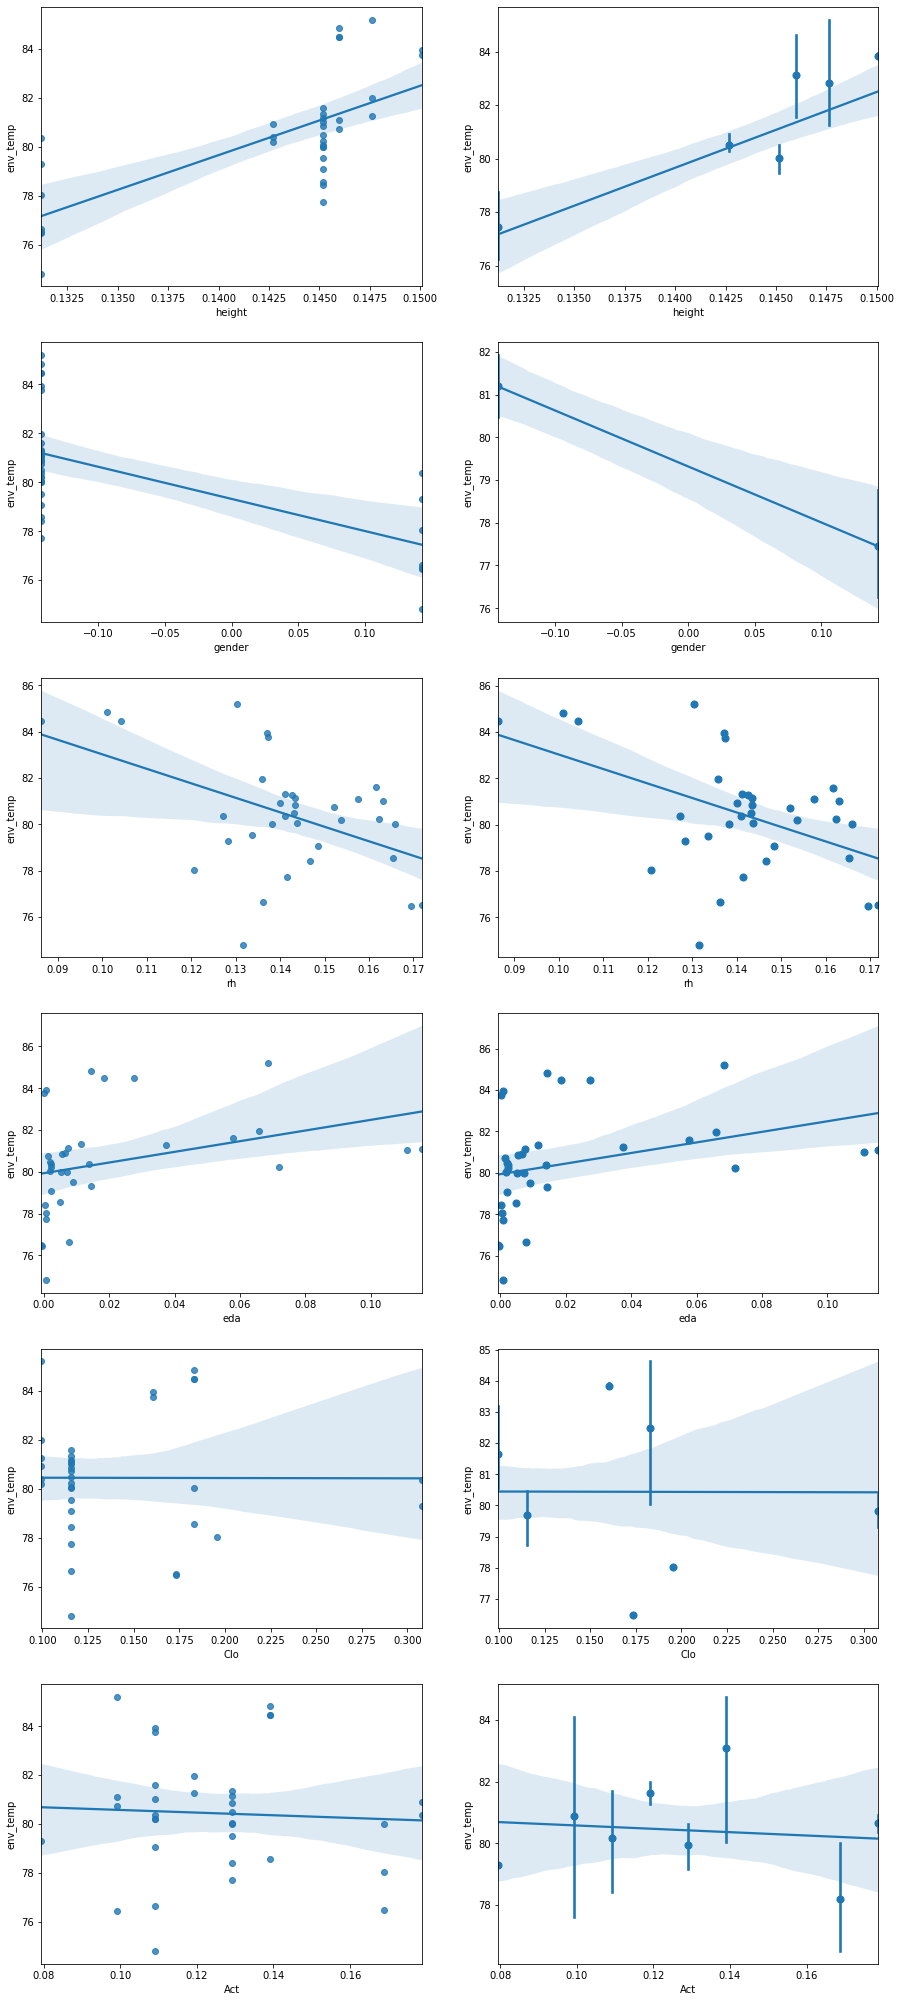

In [83]:
plt.figure(figsize=(15, 6*n_features))
i = 1
for col_n in X_train.columns:
    # left
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train)
    i += 1
    
    # right
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train, x_estimator=np.mean)
    i += 1

### multiple linear regression

In [84]:
regr = sm.OLS(y_train, X_train)

In [85]:
regr_fit = regr.fit()

In [86]:
y_pred = regr_fit.predict(X_test)

In [87]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
41,79.480,80.221654
46,80.911,79.962136
15,78.645,80.245876
6,81.023,81.806641
48,80.272,80.628369
30,72.696,76.759836
7,79.480,79.612614
10,79.480,79.134776
9,76.725,80.564868


In [88]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.611e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                    9.62e-53
Time:                        22:35:42   Log-Likelihood:                         -52.834
No. Observations:                  35   AIC:                                      117.7
Df Residuals:                      29   BIC:                                      127.0
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height       592.5690     17.156     34.541      0.000     557.482     627.656
gender        14.7620      2.632      5.609      0.000       9.379      20.145
rh           -46.5663     11.472     -4.059      0.000     -70.030     -23.102
eda           19.8206      7.428      2.668      0.012       4.628      35.013
Clo           13.8822      5.111      2.716      0.011       3.429      24.336
Act           10.5929      9.066      1.168      0.252      -7.948      29.134
==============================================================================
Omnibus:                        0.063   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.969   Jarque-Bera (JB):                0.129
Skew:                          -0.084   Prob(JB):                        0.937
Kurtosis:                       2.754   Cond. No.                         29.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
# mean squared error
mean_squared_error(y_test, y_pred)

4.016711637325011

In [90]:
# R2 score
r2_score(y_test, y_pred)

0.33686065038192525

## cross validation

In [91]:
from sklearn import metrics
# metrics
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [92]:
lr = LinearRegression()
lr_cv_mse = cross_val_score(lr, X_rm, y_data_refine, scoring='neg_mean_squared_error', cv=10)

In [93]:
lr_cv_mse

array([-1.61296915, -3.21240835, -3.38693309, -1.61101055, -0.88500778,
       -5.95497282, -2.54623113, -0.30373156, -0.59593936, -2.35997379])

In [94]:
np.abs(lr_cv_mse.mean())

2.2469177601012364